In [1]:
import datajoint as dj
import os
import sys

# Specify repository directory 
repo_directory = '/gpfs01/euler/User/avlasits/datajoint_imaging_V2-amacrine/'


# Add repository directory to %PYTHONPATH
sys.path.insert(0, repo_directory)

# Load configuration for user
dj.config.load(repo_directory + 'conf/dj_conf_avlasits.json')

# Load datajoint schema classes
#from schema.imaging_schema import *
from schema.amacrine_schema import * #we'll see if this works.

Connecting avlasits@172.25.240.205:3306


In [2]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
from sklearn.cluster import KMeans
import scipy as sp
from scipy import linalg
from sklearn.decomposition import SparsePCA
from sklearn.mixture import GaussianMixture
import scipy.linalg as la

target_user = 'Vlasits'

restriction_str = 'experimenter = "{}"'.format(target_user)

In [3]:
from matplotlib import animation, rc
from IPython.display import HTML

# Get Data

In [4]:
#field keys
field1 = dict(experimenter = "Vlasits",
           date = "2020-08-04",
           exp_num = 2, 
           field_id = 7,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 2,
           spline_params_id = 1,
)

#done
field2 = dict(experimenter = "Vlasits",
           date = "2020-08-06",
           exp_num = 1, 
           field_id = 13,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 2,
           spline_params_id = 1,
)

#xz field
field3 = dict(experimenter = "Vlasits",
           date = "2020-08-06",
           exp_num = 1, 
           field_id = 5,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 2,
           spline_params_id = 1,
)

#chat cre iglusnfr field
field4 = dict(experimenter = "Vlasits",
           date = "2020-02-05",
           exp_num = 1,
           field_id = 2,
           stim_id = 3,
           preprocess_param_set_id = 1
)

#another ubiquitous xy field that I ran later
field5 = dict(experimenter = "Vlasits",
           date = "2020-08-06",
           exp_num = 1, 
           field_id = 41,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 2,
           spline_params_id = 1,
)

#another xz field that I ran later. Same field as field1, but XZ
field6 = dict(experimenter = "Vlasits",
           date = "2020-08-04",
           exp_num = 2, 
           field_id = 9,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 2,
           spline_params_id = 1,
)


#new xz fields
field7 = dict(experimenter = "Vlasits",
           date = "2020-10-09",
           exp_num = 1, 
           field_id = 12,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 2,
           spline_params_id = 1,
)

#new xz fields
field8 = dict(experimenter = "Vlasits",
           date = "2020-10-12",
           exp_num = 2, 
           field_id = 7,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 2,
           spline_params_id = 1,
)

# meso!
field9 = dict(experimenter = "Vlasits",
           date = "2020-10-09",
           exp_num = 2, 
           field_id = 59,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 1, 
           spline_params_id = 1,
)

#xy field 128 x 32
field10 = dict(experimenter = "Vlasits",
           date = "2020-10-12",
           exp_num = 2, 
           field_id = 20,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 1,
           spline_params_id = 1,
)

##20200806 additional field that I didn't do splines on..... Good
field11 = dict(experimenter = "Vlasits",
           date = "2020-08-06",
           exp_num = 1, 
           field_id = 25,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 1,
           spline_params_id = 1,
)

## # IPL3 128x32 good
field12 = dict(experimenter = "Vlasits",
           date = "2020-10-09",
           exp_num = 2, 
           field_id = 60,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 1,
           spline_params_id = 1,
)

# #IPL1 better XZ!!
field13 = dict(experimenter = "Vlasits",
           date = "2020-10-09",
           exp_num = 2, 
           field_id = 14,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 2,
           spline_params_id = 1,
)

#new Chat field
field14 = dict(experimenter = "Korympidou",
           date = "2021-05-20",
           exp_num = 2, 
           field_id = 10,
           preprocess_param_set_id = 1,
           spline_roi_param_id = 1, #limiting to larger groups here
           spline_params_id = 1,
)

In [50]:
Animal() & 'date="2021-05-20"'

*experimenter  *date    *exp_num    genline     genbkglinerem  genline_report genline_report animspecies    animgender     animdob     animrem    
+------------+ +------+ +---------+ +---------+ +------------+ +------------+ +------------+ +------------+ +------------+ +---------+ +---------+

 (Total: 0)

In [5]:
def get_roi_sizes(field):
    #get the roi groups and scaling information
    roi_groups = (NoiseSplineROIs() & field).fetch('pixel_list')
    x_zoom = (Presentation.ScanInfo() & field).fetch1('zoom')
    roimask = (Field.RoiMask() & field).fetch1('roi_mask')
    x_dimension = roimask.shape[0]
    um_pixel_x = (71.5/x_zoom)/x_dimension
    
    #get the diameter of each ROI scaled in microns
    roi_sizes = [np.sqrt(len(x))*um_pixel_x for x in roi_groups]
    print(np.mean(roi_sizes))
    return roi_sizes

In [6]:
#check average size of rois
roi_sizes4 = get_roi_sizes(field4)
roi_sizes14 = get_roi_sizes(field14)

#warning this also includes discarded duplicates right now. Not sure it matters in this case too much.
all_rois = roi_sizes4+roi_sizes14

mean_roi_diameter = np.mean(all_rois)
print(mean_roi_diameter)

sd_roi_diameter = np.std(all_rois)
print(sd_roi_diameter)

2.3664613133332257
2.850396550802566
2.6889090841234364
0.33075811959009416


In [7]:
def get_shifted_spline_frame(field, num):
    #get data
    pix_id = (NoiseSplineAlignment() & field).fetch('center_pixel_id')
    shifted_filters =  (NoiseSplineAlignment() & field).fetch('shifted_filter')
    
    #make frame
    data = pd.DataFrame({'center_pixel_id':pix_id, 'shifted_filters':shifted_filters, 
                        })    
    data['field'] = np.ones(data.shape[0])*num
    data = data.set_index('center_pixel_id')
    
    roimask = (Field.RoiMask() & field).fetch1('roi_mask')
    coordinates = np.zeros((data.shape[0], 3))
    for index, pixel in enumerate(data.index):
        idx = np.where(roimask==pixel*-1)
        coordinates[index, 1:] = np.array([idx[1][0], idx[0][0]]) #y, x
        coordinates[index, 0] = pixel

    data['y_position']= coordinates[:,1]
    data['x_position']=coordinates[:,2]
    
    return data

In [8]:
#pull data from database into a dataframe
s_df4 = get_shifted_spline_frame(field4, 4)
s_df14 = get_shifted_spline_frame(field14, 14)

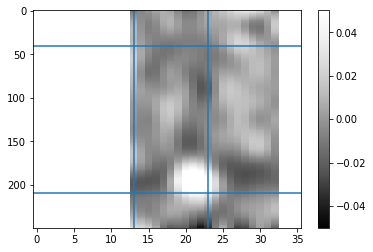

In [9]:
#plot a single ROI RF
index = 150 #using 150, 800, 5, 100, 400, 600 also look fine
plt.imshow(s_df4['shifted_filters'].iloc[index], aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05) #examples: 5, 150, 100, 400, 600, 800

plt.colorbar()

axes=plt.gca()
axes.axhline(40)
axes.axhline(s_df4['shifted_filters'].iloc[index].shape[0]-40)
axes.axvline(13)
axes.axvline(23)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Example_spline"+str(index)+".pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

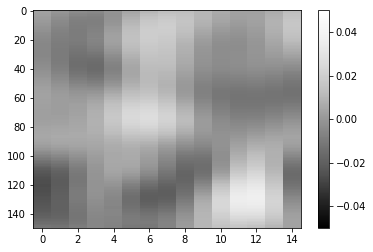

In [10]:
#an example from the other field
index = 150 #
plt.imshow(s_df14['shifted_filters'].iloc[index][50:-50, 13:28], aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
plt.colorbar()

axes=plt.gca()
# axes.axhline(50)
# axes.axhline(s_df13['shifted_filters'].iloc[roi_num].shape[0]-50)
# axes.axvline(12)
# axes.axvline(19)


# Figpath = 'Fig_temp/'
# savename = Figpath+"example_rf_iloc"+str(index)+"cropped_out.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

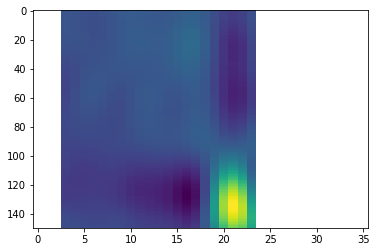

In [11]:
#average of all ROIs from the field
plt.imshow(s_df14['shifted_filters'].mean(skipna=True)[50:-50,4:], aspect='auto')

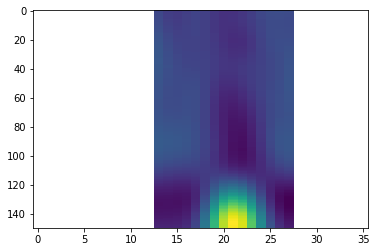

In [12]:
#average of all ROIs from the field
plt.imshow(s_df4['shifted_filters'].mean(skipna=True)[50:-50,:], aspect='auto')

176
184


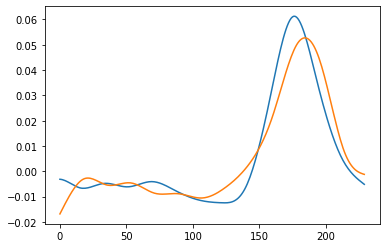

In [13]:
#comparing the centers for each field to fix temporal offset
center_avg4 = s_df4['shifted_filters'].mean(skipna=True)[20:,21]
center_avg14 = s_df14['shifted_filters'].mean(skipna=True)[:-20,21+4]

plt.plot(center_avg4)
plt.plot(center_avg14)

axes=plt.gca()
# axes.axvline(x=np.argmax(average_on_filter14[21,:]))
# axes.axvline(x=np.argmax(average_on_filter4[21,:]))

print(np.argmax(center_avg4))
print(np.argmax(center_avg14))



In [14]:
#realigning timing since the stimulator delay was not taken into account and has changed between these two fields

shift = 20 #old stim delay, 34, new is 75. 41 ms difference. 2ms per point here, so 20 points

#first cropping s_df4 by the time offset
splines = np.asarray(s_df4['shifted_filters'])
cropped_splines4 = []

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_cropped = spline[shift:,:]
#     s_df4['shifted_filters_corr'].iloc[i] = current_spline_cropped
    cropped_splines4.append(current_spline_cropped)
    
#now cropping s_df14 by the time offset and the remaining space offset
splines = np.asarray(s_df14['shifted_filters'])
cropped_splines14 = []

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_cropped = spline[:-1*(shift),4:]
    cropped_splines14.append(current_spline_cropped)
#     s_df14['shifted_filters_corr'].iloc[i] = current_spline_cropped

s_df4['shifted_filters_corr']=cropped_splines4
s_df14['shifted_filters_corr']=cropped_splines14 #going to do interpolation to get the right filter size again


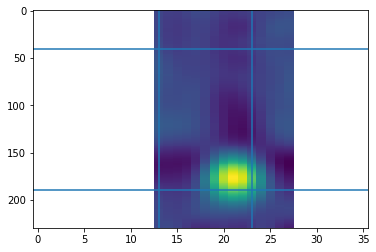

In [15]:
#final mean filters
plt.imshow(s_df4['shifted_filters_corr'].mean(skipna=True)[:,:], aspect='auto')

axes=plt.gca()
axes.axhline(40)
axes.axhline(s_df4['shifted_filters_corr'].iloc[0].shape[0]-40)
axes.axvline(13)
axes.axvline(23)


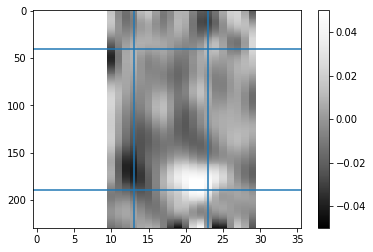

In [16]:
#more example filters
index = 800 #using 150, 800, 5, 100, 400, 600 also look fine
plt.imshow(s_df4['shifted_filters_corr'].iloc[index], aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05) #examples: 5, 150, 100, 400, 600, 800

plt.colorbar()

axes=plt.gca()
axes.axhline(40)
axes.axhline(s_df4['shifted_filters_corr'].iloc[index].shape[0]-40)
axes.axvline(13)
axes.axvline(23)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Example_spline"+str(index)+".pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

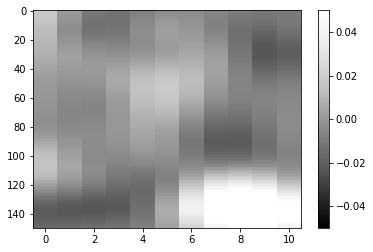

In [17]:
#cropped filter used for clustering
index = 150 #
plt.imshow(s_df4['shifted_filters_corr'].iloc[index][40:-40, 13:24], aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
plt.colorbar()

axes=plt.gca()
# axes.axhline(50)
# axes.axhline(s_df13['shifted_filters'].iloc[roi_num].shape[0]-50)
# axes.axvline(12)
# axes.axvline(19)


# Figpath = 'Fig_temp/'
# savename = Figpath+"example_rf_iloc"+str(index)+"cropped_out.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

# Prepare for clustering

In [18]:
# concatenate data from both fields
s_df_xz = pd.concat([s_df4, s_df14])

In [19]:
#flattening
splines = np.asarray(s_df_xz['shifted_filters_corr'])
spline_array = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))
spline_array_cropped = np.zeros((splines.shape[0], 150*10))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten(order='F')
    spline_array[i,:] = current_spline_flat
    
    current_spline_cropped = spline[40:-40,13:23]
    current_spline_cropped_flat = current_spline_cropped.flatten()#order='F'
    spline_array_cropped[i,:] = current_spline_cropped_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

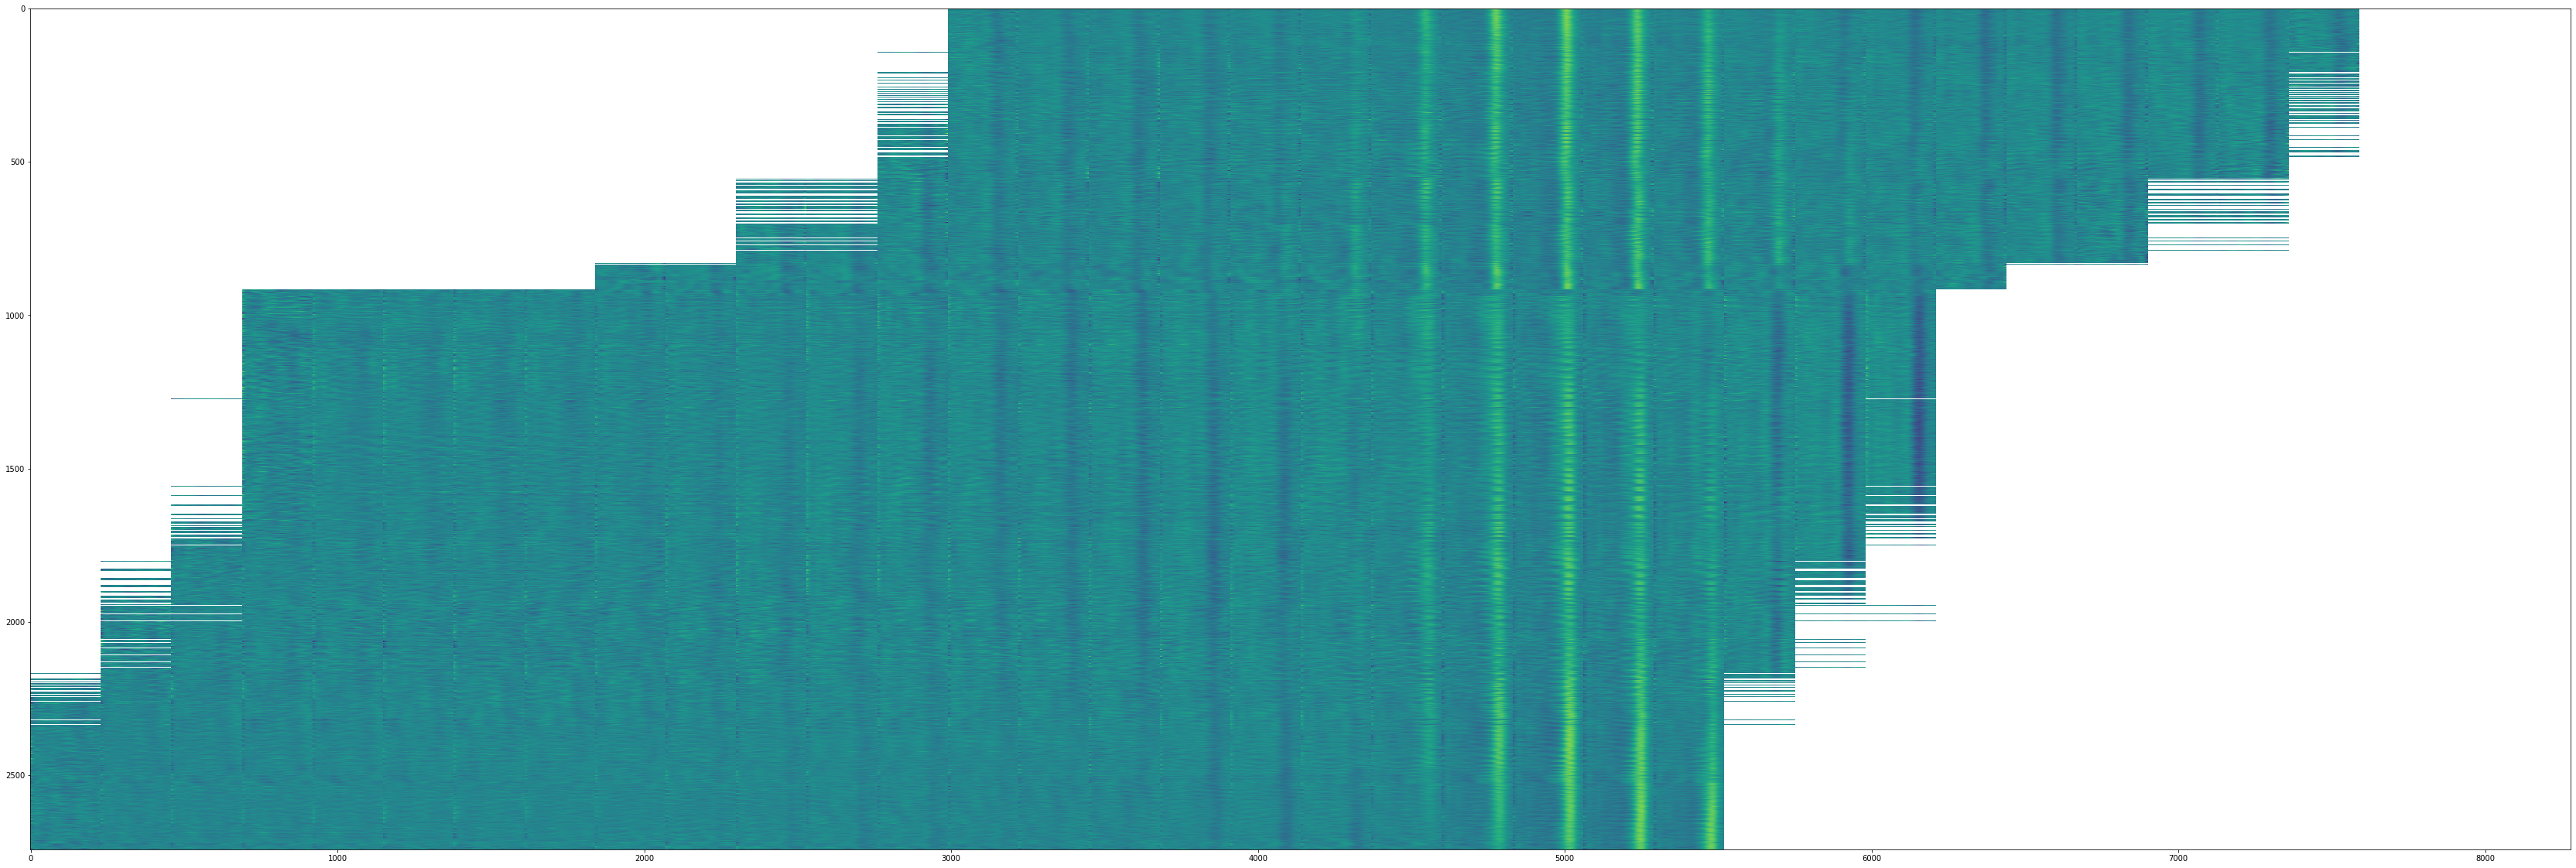

In [20]:
#plot flattened array
fig = plt.figure(figsize=(60,20))
plt.imshow(spline_array)

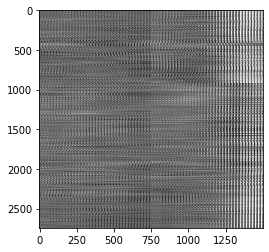

In [21]:
#now cropped array for clustering
fig = plt.figure(figsize=(4,4))
plt.imshow(spline_array_cropped, aspect='auto', cmap='Greys_r')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cropped_Flattened_splines_chat.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

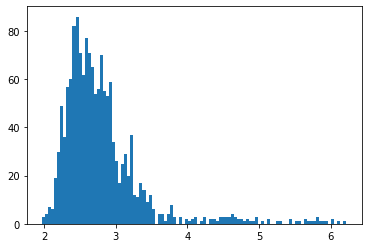

In [22]:
#check for low quality rois
zscored_spline_array = ((spline_array_cropped.T-np.mean(spline_array_cropped, axis=1))/np.std(spline_array_cropped, axis=1)).T

plt.hist(np.amax(np.abs(zscored_spline_array), axis=0), bins=100)
plt.show()

In [23]:
#remove low quality rois
threshold = 2.2
quality_mask = np.where(np.amax(np.abs(zscored_spline_array), axis=1)>threshold)

s_df_xz_masked = s_df_xz.iloc[quality_mask].copy()

s_df_xz_masked.shape

(2725, 5)

# Mixture of Gaussian Model

In [24]:
#Pull cluster assignment from the database

cluster_group = 'spline_cluster_params_id = 2'

field_list_all_xz = [field4, field14]
field_nums_xz = [4, 14]

cluster_assignments=[]

for i, field in enumerate(field_list_all_xz):
    cluster_assignments_field = list((NoiseSplineClusterAssignment() & field & cluster_group).fetch('cluster_assignment'))
    
    cluster_assignments = cluster_assignments + cluster_assignments_field

s_df_xz_masked['new_cluster_assignment'] = cluster_assignments

# Evaluating clustering and measuring cluster parameters

In [25]:
#make averages
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

average_filters = np.zeros((s_df_xz_masked['shifted_filters_corr'].iloc[0].shape[0], s_df_xz_masked['shifted_filters_corr'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = s_df_xz_masked[s_df_xz_masked['new_cluster_assignment']==clust]    
    current_mean = np.nanmean(np.dstack(current_frame['shifted_filters_corr']), axis=2)
    average_filters[:,:,i] = current_mean

 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:Mean of empty slice


In [26]:
#find ROI positions for plotting
s_df_xz_copy = s_df_xz_masked.copy(deep=True)
s_df_xz_copy = s_df_xz_copy.set_index(['new_cluster_assignment'])

cluster_avg_depth = s_df_xz_copy['x_position'].groupby(['new_cluster_assignment']).mean()

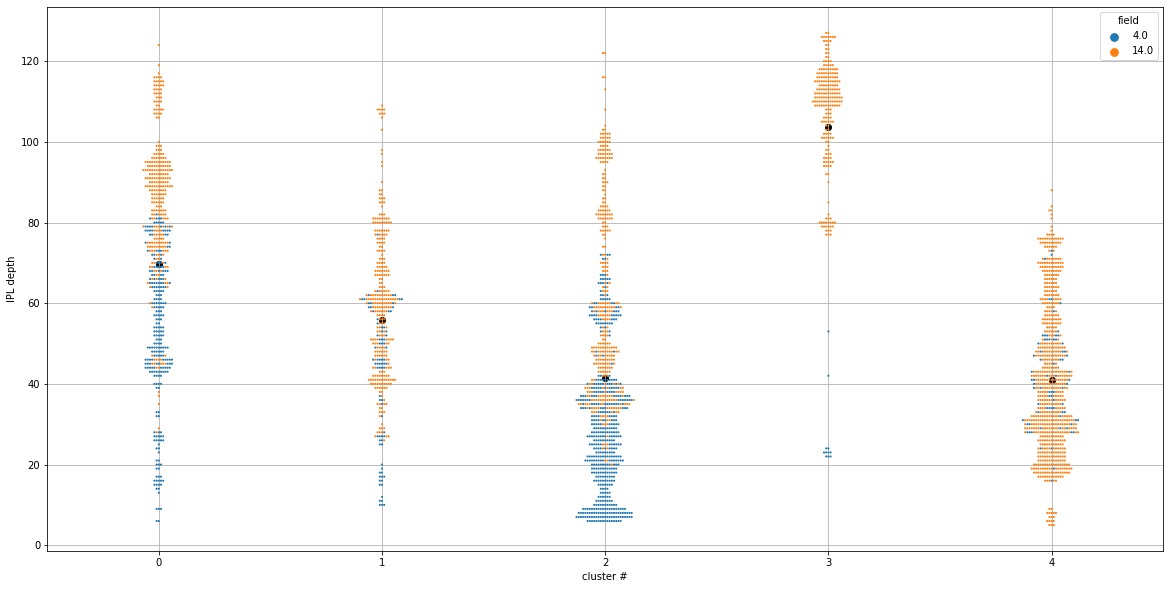

In [27]:
#plot ROI positions in field by cluster
n_bins = 10
current_palette = sns.color_palette()

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

c = s_df_xz['field']

fig=plt.figure(figsize=(20,10))


ax = sns.swarmplot(data=s_df_xz_masked, x="new_cluster_assignment", y="x_position", hue="field", alpha=1, cmap=cm, size=2.1,)
# plt.scatter(s_df_xz['new_cluster_assignment'], s_df_xz['depth'], alpha=0.3, c=c, cmap=cm)
# plt.colorbar()
plt.scatter(cluster_avg_depth.index, cluster_avg_depth, color='k')

axes = plt.gca()
axes.set_xlabel('cluster #')
axes.set_ylabel('IPL depth')
plt.grid(True)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_ipl_depth_chat.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

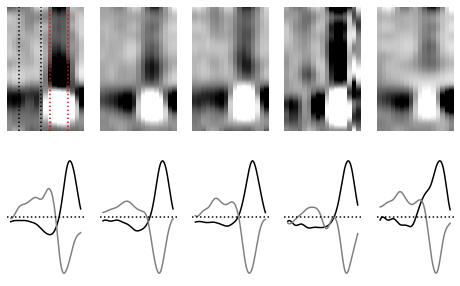

In [28]:
#plot cluster average RFs and normalized temporal kernels
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, 1, 1, 1, 1,1,1,1,]
latency = np.zeros(len(polarity))
surround_strength = np.zeros(len(polarity))

fig, ax = plt.subplots(2, 5, figsize=(8, 5))

for i, clust in enumerate(clusters):

#     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12)
    ax[0, i].imshow(average_filters[:,10:27,i]/np.linalg.norm(average_filters[50:-50,11:19,i]), aspect='auto', cmap='Greys_r', vmin=-0.08, vmax=0.08)
    ax[0, i].axis('off')
#     ax[0, i].colorbar()

    if i == 0:
        ax[0, i].axvline(12-10, color='k', linestyle='dotted')
        ax[0, i].axvline(17-10, color='k', linestyle='dotted')
        ax[0, i].axvline(19-10, color='r', linestyle='dotted')
        ax[0, i].axvline(23-10, color='r', linestyle='dotted')
    
    avg_filter_flipped = average_filters[:,:,i]*polarity[i] #deal with off cells
    center = np.mean(avg_filter_flipped[:,19:24], axis=1)/np.amax(np.mean(avg_filter_flipped[100:240,19:24], axis=1))
    surround = np.mean(avg_filter_flipped[:,12:18], axis=1)/np.amin(np.mean(avg_filter_flipped[100:240,12:18], axis=1))
    ax[1, i].plot(np.mean(avg_filter_flipped[15:-15,19:24], axis=1)/np.amax(np.mean(avg_filter_flipped[100:240,19:24], axis=1)), color='k')
    ax[1, i].plot(np.mean(avg_filter_flipped[15:-15,12:18], axis=1)/np.amin(np.mean(avg_filter_flipped[100:200,12:18], axis=1))*-1, color='grey')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[1, i].axhline(color='k', linestyle='dotted')
    ax[1, i].set_yticklabels([])
    ax[1, i].set_xticklabels([])
    ax[1, i].axis('off')
    
    latency[i] = np.argmax(center)-np.argmax(surround)
    surround_strength[i] = np.amin(np.mean(avg_filter_flipped[100:240,12:18], axis=1))/np.amax(np.mean(avg_filter_flipped[100:240,19:24], axis=1))

# plt.colorbar()
# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_chat_scale_flipped.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

In [29]:
real_time_lag, time_points = (NoiseDesignMatrix2() & field4).fetch1('real_time_lag', 'time_points')
time_points, real_time_lag

(250, 0.5)

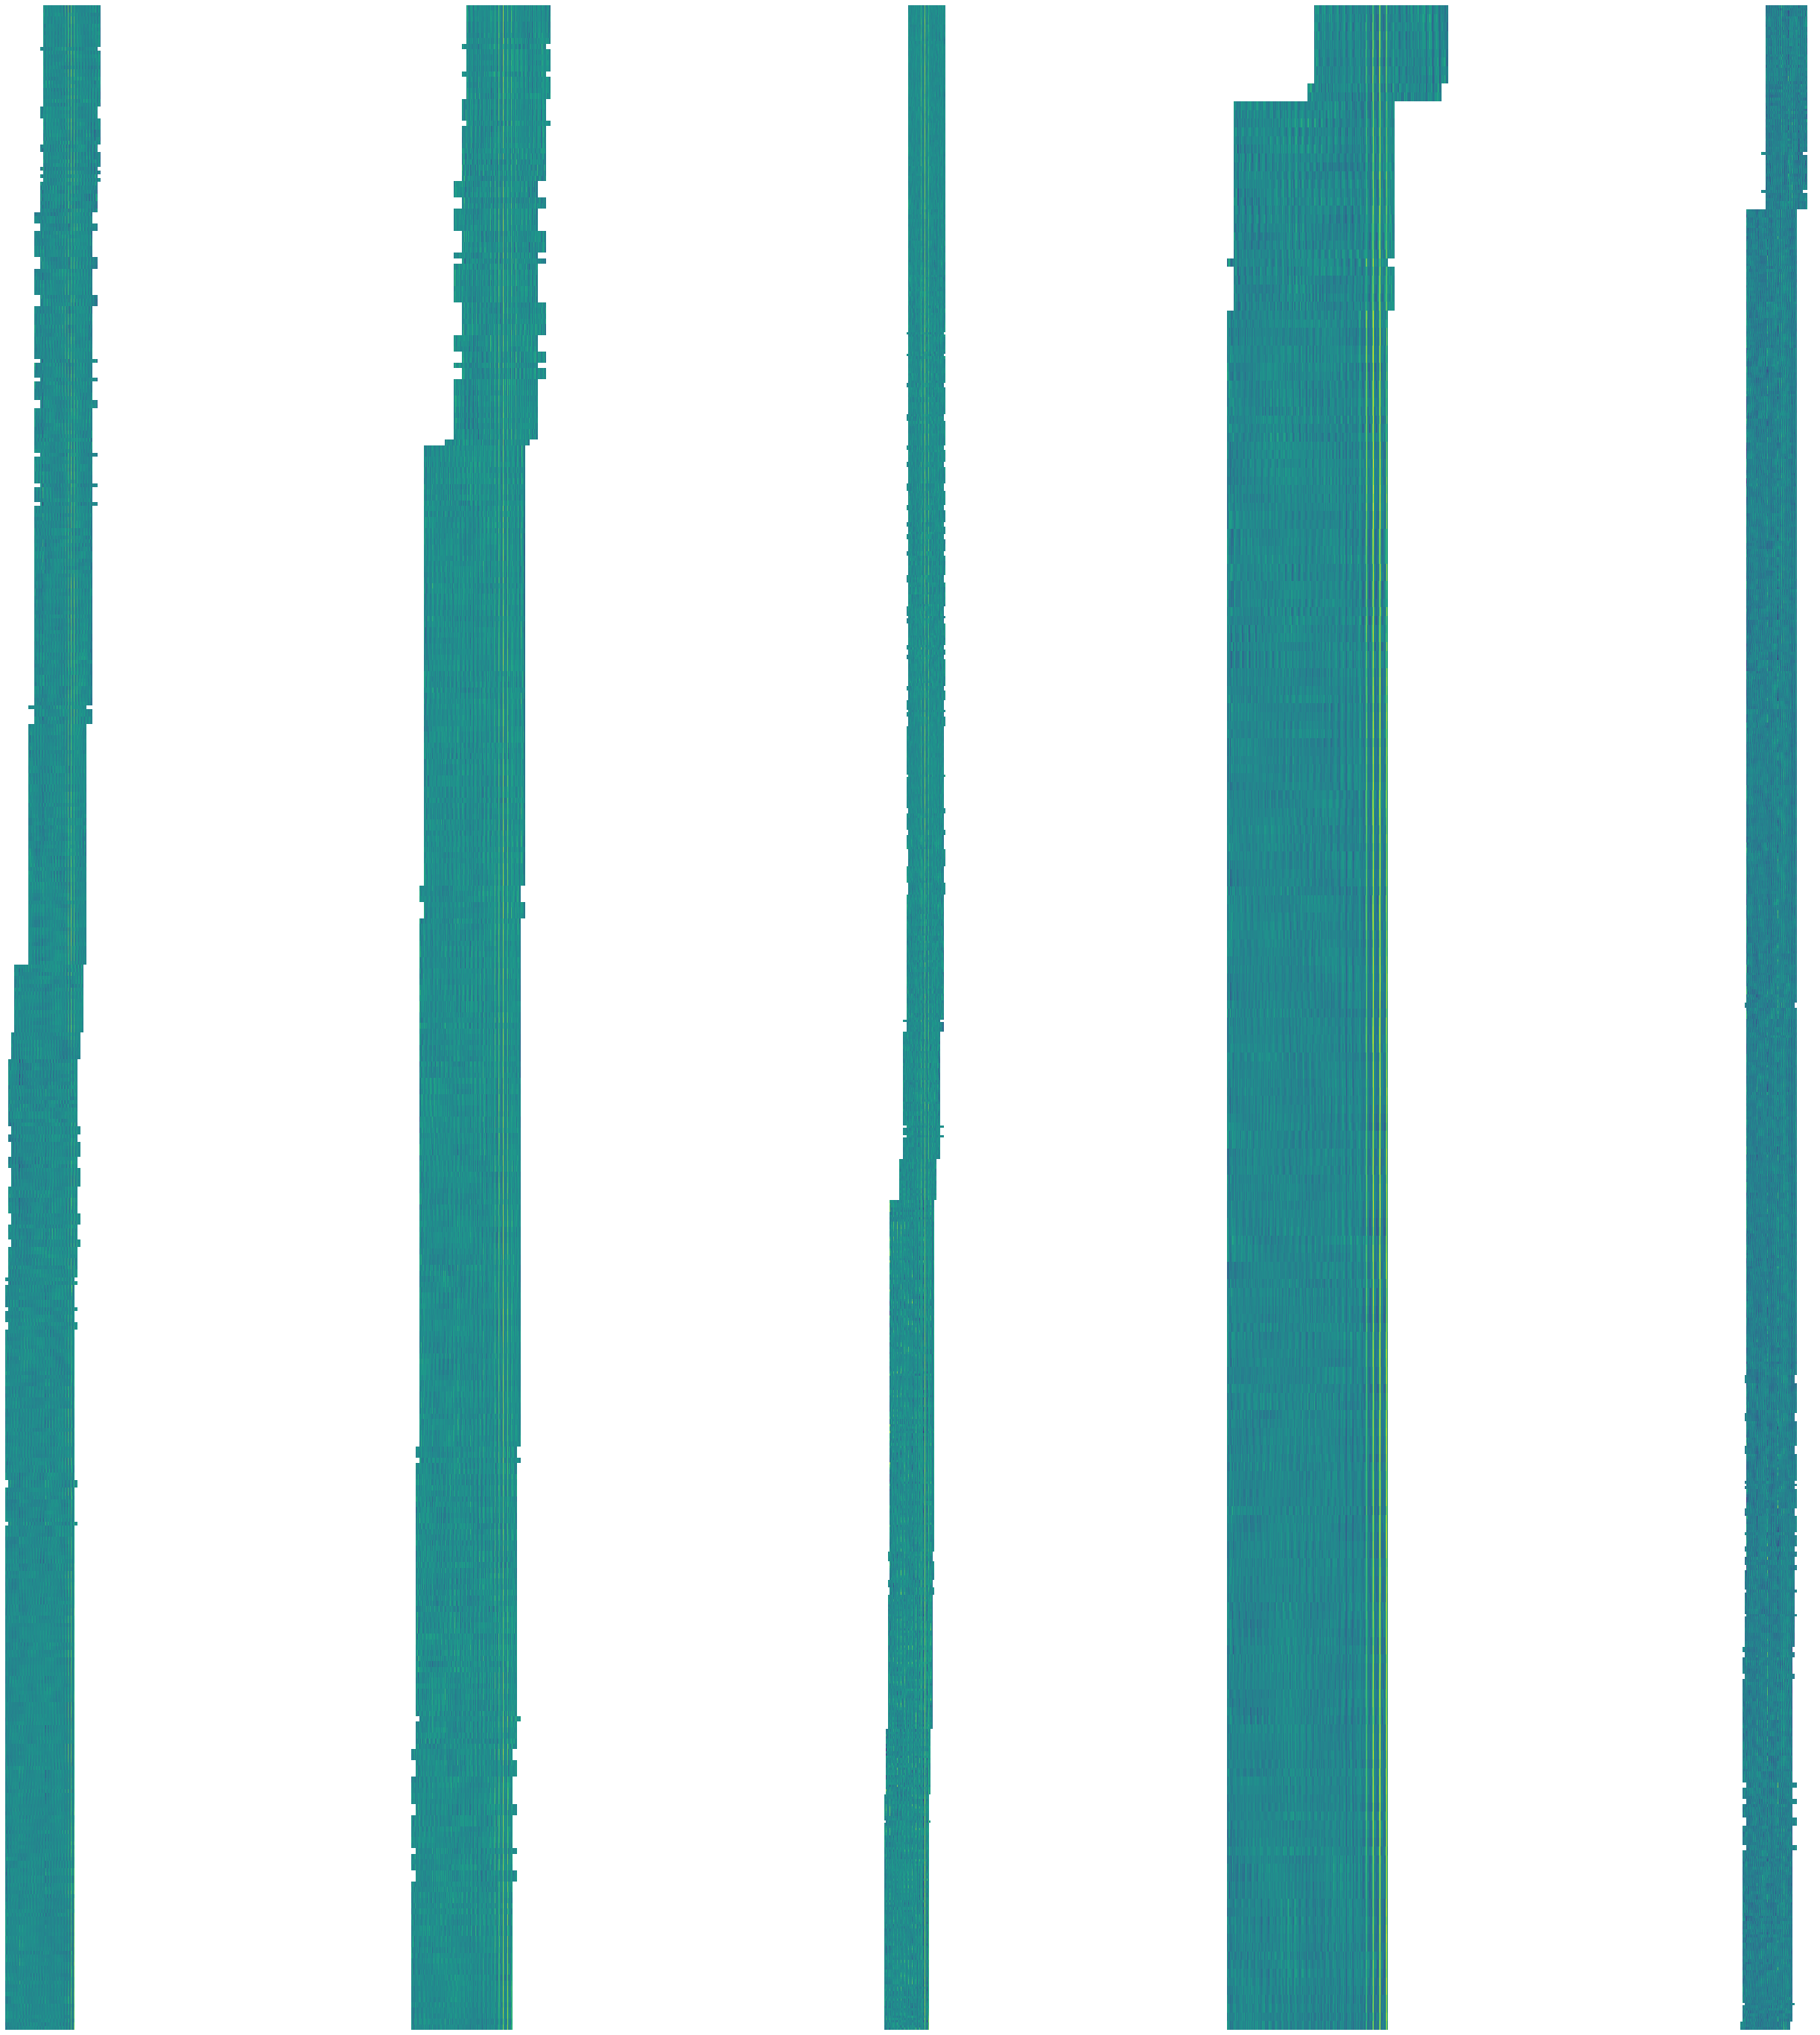

In [30]:
# by-cluster flattened responses
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, 1, 1, 1, 1,]

fig, ax = plt.subplots(1, 5, figsize=(50, 50))
for i in range(5):
    
    ax[i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==i], cmap='viridis', aspect=300,) 
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

In [31]:
# response in center vs. surround for each individual ROI

center_single_rois = np.nanmean(np.dstack(s_df_xz_masked['shifted_filters_corr'])[:,19:24,:], axis=1)
surround_single_rois = np.nanmean(np.dstack(s_df_xz_masked['shifted_filters_corr'])[:,12:18,:], axis=1)

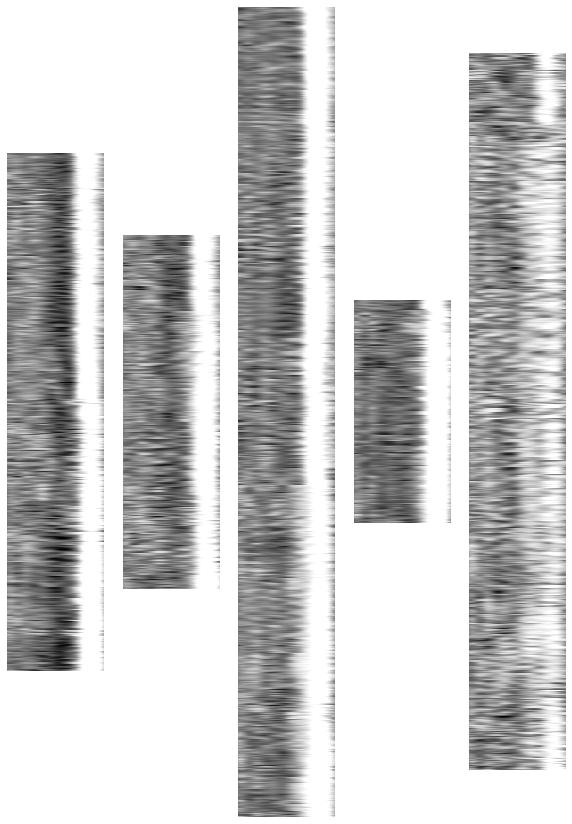

In [32]:
#center responses by roi/cluster
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

range_vals = 0.03

fig, ax = plt.subplots(1, 5, figsize=(10, 20))
for i in range(5):
   
    ax[i].imshow(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==i].T, cmap='Greys_r', aspect=2, vmin=-range_vals, vmax=range_vals) 
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    
#     ax[1, i].imshow(surround_single_rois[:, s_df_xz_masked['new_cluster_assignment']==i].T, cmap='Greys_r', aspect=3, vmin=-range_vals, vmax=range_vals) 
#     ax[1, i].set_yticklabels([])
#     ax[1, i].set_xticklabels([])
#     ax[1, i].axis('off')
    

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_individual_roi_centers.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

(538, 200)
(368, 200)
(842, 200)
(232, 200)
(745, 200)


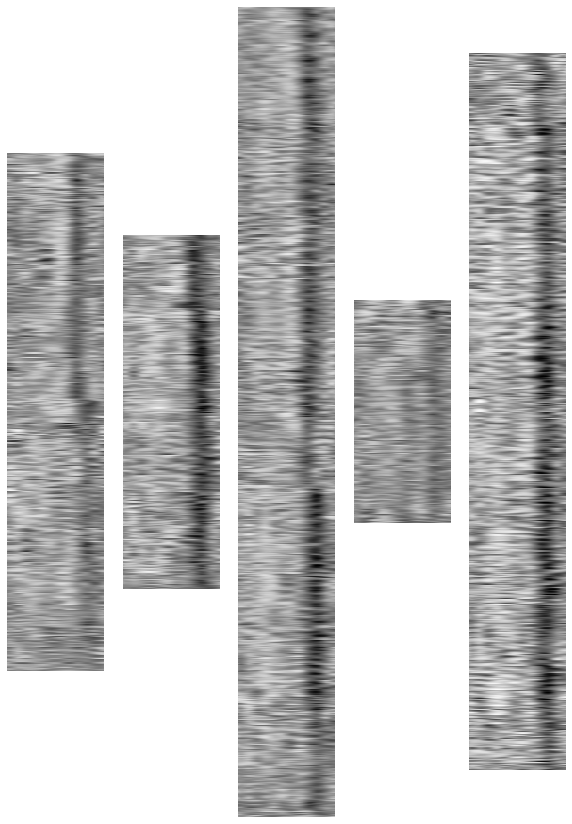

In [33]:
#surround responses by roi/cluster
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

range_vals = 0.03

fig, ax = plt.subplots(1, 5, figsize=(10, 20))
for i in range(5):
   
    #     ax[i].imshow(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==i].T, cmap='Greys_r', aspect=2, vmin=-range_vals, vmax=range_vals) 
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')
    
    ax[i].imshow(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==i].T, cmap='Greys_r', aspect=2, vmin=-range_vals, vmax=range_vals) 
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    print(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==i].T.shape)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_individual_roi_surrounds.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

# Cluster summary data

In [34]:
def get_svg_parameters_on_screen(dendrite_length, moving_bar_length, stimulus_velocity,
                             starting_point, distance_covered, real_time_lag, time_points, space_per_pixel):
    temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
    spatial_conversion = 1 / space_per_pixel  # From um to pixel.

    # Moving bar is already fully on screen at t = 0
    distance_moved = distance_covered - moving_bar_length  # [um]
    stimulation_time = (distance_moved / stimulus_velocity)  # [s]

    # Convert from seconds & um to pixel
    stimulation_time_pixel = stimulation_time * temporal_conversion

    distance_moved_pixel = distance_moved * spatial_conversion
    dendrite_length_pixel = dendrite_length * spatial_conversion
    moving_bar_length_pixel = moving_bar_length * spatial_conversion
    starting_point_pixel = starting_point * spatial_conversion
    distance_covered_pixel = distance_covered * spatial_conversion

    # Slope of diagonal
    slope = -stimulation_time_pixel / distance_moved_pixel

    # Calculate thickness of diagonal
    alpha = np.arctan(stimulation_time_pixel / distance_moved_pixel)
    diagonal_thickness = moving_bar_length_pixel * np.sin(alpha)

    # Calculate coordinates for beginning & end of diagonal
    # Diagonal starts and ends out of picture to allow for a smooth & exact picture.
    x_start = starting_point_pixel
    x_stop = x_start + distance_covered_pixel

    y_start = (moving_bar_length_pixel / 2) * slope  # Negative
    y_stop = stimulation_time_pixel - y_start

    return (stimulation_time_pixel, dendrite_length_pixel,
            diagonal_thickness,
            x_start, x_stop, y_start, y_stop)

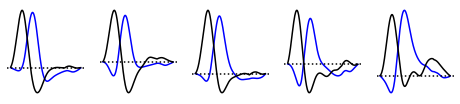

In [35]:
#plot model responses for 1000 um/s

# get the stimulus for convolution across half kernel

convolution_stim_params_id = 'convolution_stim_params_id = 1'
field = field4

convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 140
convolution_params['distance_covered'] = 140
real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Stimulus_images/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))



dsi = np.zeros(average_filters.shape[2])
#get convolved responses
fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
for i in range(average_filters.shape[2]):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters[:,10:32,i]
    edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
    # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
    # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-edge_buffer, :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
#     peak_y = index_max[1]
#     print(peak_y)
    peak_y = 11

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y):np.int(peak_y + kernel_length)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(np.abs(response))
    max_response_rev = np.amax(np.abs(response_rev))
    dsi[i] = (max_response - max_response_rev) / (max_response + max_response_rev)
#     print(dsi)

    ax[i].plot(response, color='b')
    ax[i].plot(response_rev, color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    
# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_chat_1000_right.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

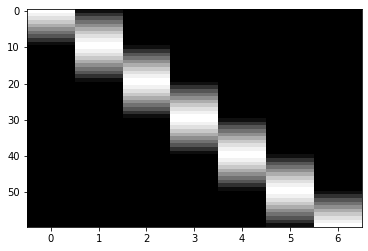

In [36]:
#plot of stimulus image
plt.imshow(stimulus_image, cmap='Greys_r', aspect='auto')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_inward_right.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

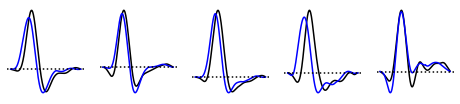

In [37]:
# convolution across full kernel

convolution_stim_params_id = 'convolution_stim_params_id = 1'
field = field4

convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 240
convolution_params['distance_covered'] = 240
real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Stimulus_images/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))



dsi = np.zeros(average_filters.shape[2])
#get convolved responses
fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
for i in range(average_filters.shape[2]):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters[:,10:32,i]
    edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
    # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'centered'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
    # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-edge_buffer, :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
#     peak_y = index_max[1]
    peak_y = 11

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y):np.int(peak_y + kernel_length)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2+1)]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(np.abs(response))
    max_response_rev = np.amax(np.abs(response_rev))
    dsi[i] = (max_response - max_response_rev) / (max_response + max_response_rev)
#     print(dsi)

    ax[i].plot(response, color='k')
    ax[i].plot(response_rev, color='b')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    
Figpath = 'Fig_temp/'
savename = Figpath+"Clusters_chat_1000_centered.pdf"
plt.savefig(savename, transparent=True, bbox_inches='tight')

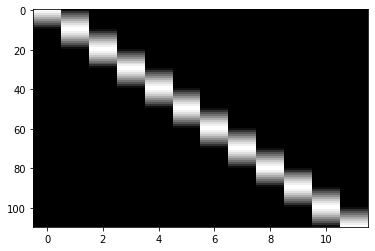

In [38]:
#stimulus image
plt.imshow(stimulus_image, cmap='Greys_r', aspect='auto')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_inward_full.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [39]:
def convolved_dsis_left(velocity):
    # velocity tuning

    # get the stimulus for convolution

    convolution_stim_params_id = 'convolution_stim_params_id = 1'
    field = field4

    convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
    real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
    space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Stimulus_images/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

    cluster_list = [0, 1, 2, 3, 4]
    dsi = np.zeros(5)
    dsi_off = np.zeros(5)

    if velocity == 1000:
        fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
    
#     fig, ax = plt.subplots(1, 5, figsize=(20, 1.6666))
    for i in cluster_list:
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,10:32,i]
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 10

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y):np.int(peak_y + kernel_length)] #changing this to try to center better
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[i] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
#         dsi_off[i] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
        dsi_all = dsi#np.where(cluster_avg_depth<0.5, dsi, dsi_off)
        
        if velocity == 1000:
            
            ax[i].imshow(spline_cut, aspect='auto', cmap='Greys_r')
            ax[i].set_yticklabels([])
            ax[i].set_xticklabels([])
            ax[i].axis('off')
            Figpath = 'Fig_temp/'
            savename = Figpath+"Clusters_chat_1000_croppedKernels_right.pdf"
            plt.savefig(savename, transparent=True, bbox_inches='tight')
        
    #     print(dsi, dsi_off)
    #     plt.figure()
#         ax[i].plot(response*polarity[i], color='b')
#         ax[i].plot(response_rev*polarity[i], color='k')
#         ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

In [40]:
def convolved_dsis_centered(velocity):
    # velocity tuning

    # get the stimulus for convolution

    convolution_stim_params_id = 'convolution_stim_params_id = 2'
    field = field4

    convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 260
    convolution_params['distance_covered'] = 260
    real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
    space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Stimulus_images/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

    cluster_list = [0, 1, 2, 3, 4]
    dsi = np.zeros(5)
    dsi_off = np.zeros(5)

    if velocity == 1000:
        fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
    
#     fig, ax = plt.subplots(1, 5, figsize=(20, 1.6666))
    for i in cluster_list:
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,10:32,i]
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'centered'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 11

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y):np.int(peak_y + kernel_length)] #changing this to try to center better
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2+1)]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[i] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
#         dsi_off[i] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
        dsi_all = dsi#np.where(cluster_avg_depth<0.5, dsi, dsi_off)
        
        if velocity == 1000:
            
            ax[i].imshow(spline_cut, aspect='auto', cmap='Greys_r')
            ax[i].set_yticklabels([])
            ax[i].set_xticklabels([])
            ax[i].axis('off')
            Figpath = 'Fig_temp/'
            savename = Figpath+"Clusters_chat_1000_croppedKernels_centered.pdf"
            plt.savefig(savename, transparent=True, bbox_inches='tight')
        
    #     print(dsi, dsi_off)
    #     plt.figure()
#         ax[i].plot(response*polarity[i], color='b')
#         ax[i].plot(response_rev*polarity[i], color='k')
#         ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

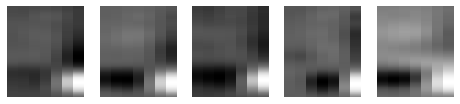

In [41]:
#run models of half RF
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_left = np.zeros((len(velocities), 5))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_left(velocity)
    dsi_all_all_left[i, :] = dsi#np.where(cluster_avg_depth<0.5, dsi, dsi_off)

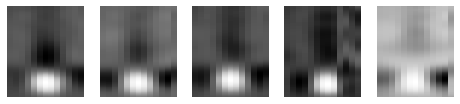

In [42]:
#run models of full RF
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_centered = np.zeros((len(velocities), 5))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_centered(velocity)
    dsi_all_all_centered[i, :] = dsi#np.where(cluster_avg_depth<0.5, dsi, dsi_off)

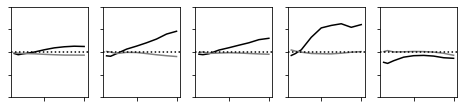

In [46]:
#plot tuning curves
fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
for i in range(5):

#     ax[i].plot(velocities, dsi_all_all[:, i]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_left[:, i]*-1, color='k')
#     ax[i].plot(velocities, dsi_all_all_full[:, i], color='grey')
    ax[i].plot(velocities, dsi_all_all_centered[:, i]*-1, color='grey')
    ax[i].set_ylim([-1, 1])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])


Figpath = 'Fig_temp/'
savename = Figpath+"Clusters_chat_velocity_curves_rightcentered_corrected.pdf"
plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

In [44]:
# comparison with ubiquitous iglusnfr clustering

ubiquitous_cluster_dsis = np.load('dsi_all_all_ubiquitous.npy')
ipl_depth_order = [0, 3, 9, 7, 11, 2, 8, 5, 6, 1, 10, 12, 4]

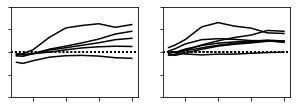

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(5, 1.6666))
# colors3 = cm.get_cmap('winter')
for i in range(5):

#     ax[i].plot(velocities, dsi_all_all[:, i]*-1, color='k')
    ax[0].plot(velocities, dsi_all_all_left[:, i]*-1, label=str(i), color='k') #color=colors3(np.amax(dsi_all_all_right[:, i])*5))

    ax[0].set_ylim([-1, 1])
    ax[0].axhline(color='k', linestyle='dotted')
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
#     ax[0].legend()

for i in ipl_depth_order[:7]:
    ax[1].plot(velocities, ubiquitous_cluster_dsis[:, i]*-1, color='k')#color=colors3(np.amax(ubiquitous_cluster_dsis[:, i]*-1)*5)) #

    ax[1].set_ylim([-1, 1])
    ax[1].axhline(color='k', linestyle='dotted')
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])

Figpath = 'Fig_temp/'
savename = Figpath+"Comparison_with_ubiquitous_xz_corrected.pdf"
plt.savefig(savename, transparent=True, bbox_inches='tight')

In [ ]:
real_time_lag, time_points

# Scrap

In [ ]:
# clustering
ZSign = cluster.hierarchy.linkage(spline_array_cropped, 'ward')
ListLeavesSign = np.flipud(cluster.hierarchy.leaves_list(ZSign))
TimeTracesSign = np.copy(spline_array)
TimeTracesOrderedSign = TimeTracesSign[ListLeavesSign]

In [ ]:
figure = plt.figure(figsize=(20,20))
plt.imshow((TimeTracesOrderedSign), aspect=5, cmap='Greys_r')

In [ ]:
# flattening
t_value = 3.5
criterion = 'distance' #'maxclust' 
pixel_assignment = cluster.hierarchy.fcluster(ZSign, t_value, criterion=criterion)
n_clusters = np.unique(pixel_assignment).shape[0]
print(n_clusters)
s_df_xz['new_cluster_assignment']=pixel_assignment

In [ ]:
s_df_xz_copy = s_df_xz.copy(deep=True)
s_df_xz_copy = s_df_xz_copy.set_index(['new_cluster_assignment'])

cluster_avg_depth = s_df_xz_copy['depth'].groupby(['new_cluster_assignment']).mean()

In [ ]:
n_bins = 10
current_palette = sns.color_palette()

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

# c = s_df_xz['field']

fig=plt.figure(figsize=(20,10))


plt.scatter(s_df_xz['new_cluster_assignment'], s_df_xz['depth'], alpha=0.05, color = 'k')#, c=c, cmap=cm)
plt.colorbar()
plt.scatter(cluster_avg_depth.index, cluster_avg_depth, color='r')

axes = plt.gca()
axes.set_xlabel('cluster #')
axes.set_ylabel('IPL depth')
plt.grid(True)



In [ ]:
clusters = np.unique(np.array(s_df_xz['new_cluster_assignment']))

average_filters = np.zeros((s_df_xz['shifted_filters'].iloc[0].shape[0], s_df_xz['shifted_filters'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = s_df_xz[s_df_xz['new_cluster_assignment']==clust]    
    current_mean = np.nanmean(np.dstack(current_frame['shifted_filters']), axis=2)
    average_filters[:,:,i] = current_mean

In [ ]:
plt.imshow(average_filters[:,:,3], aspect='auto')

In [ ]:
filter_range = average_filters.shape[2]#-np.int(np.floor(0.25*average_filters.shape[2]))
img = average_filters[:,:,0:filter_range] # some array of images

maximum = 0.75*np.nanmax(img)
minimum = 0.3*np.nanmin(img)

frames = [] # for storing the generated images
fig = plt.figure()
for i in range(img.shape[2]):
    frames.append([plt.imshow(img[:,:,i], cmap='Greys_r', aspect=0.1, animated=True, vmax=maximum, vmin=minimum)]) #cm.viridis

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=10)
# ani.save('test_movie.mp4')
plt.show()

In [ ]:
HTML(ani.to_jshtml())

In [ ]:
clusters = np.unique(np.array(s_df_xz['new_cluster_assignment']))
for i, clust in enumerate(clusters):
    fig, ax = plt.subplots(1, 2, figsize=(5, 2))
    ax[0].imshow(spline_array[s_df_xz['new_cluster_assignment']==clust], aspect=12)
    ax[1].imshow(average_filters[:,:,i]/np.linalg.norm(average_filters[50:-50,11:19,i]), aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)

# scrap

In [ ]:
the_frame = s_df3

n_bins = 36
current_palette = sns.color_palette() #"viridis"

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

c = the_frame['cluster_assignment']

plt.scatter(the_frame['x_position'], the_frame['z_position'], c=c, cmap=cm)

plt.colorbar()

plt.show()

In [ ]:
# n_bins = 10
# current_palette = sns.color_palette()

# # cmap_name = 'my_list'
# # cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

# # c = s_df_xz['field']

fig=plt.figure(figsize=(20,10))


plt.scatter(the_frame['cluster_assignment'], the_frame['depth'], alpha=1)#, c=c, cmap=cm, )

axes = plt.gca()
plt.grid(True)

plt.colorbar()

In [ ]:
average_filters = average_filters3

In [ ]:
filter_range = average_filters.shape[2]#-np.int(np.floor(0.25*average_filters.shape[2]))
img = average_filters[:,:,0:filter_range] # some array of images

maximum = 0.75*np.nanmax(img)
minimum = 0.75*np.nanmin(img)

frames = [] # for storing the generated images
fig = plt.figure()
for i in range(img.shape[2]):
    frames.append([plt.imshow(img[:,:,i], cmap='Greys_r', aspect=0.1, animated=True, vmax=maximum, vmin=minimum)]) #cm.viridis

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=10)
# ani.save('test_movie.mp4')
plt.show()

In [ ]:
HTML(ani.to_jshtml())

In [ ]:
frames = [mean_df3, mean_df6, mean_df7, mean_df13]
colors = ['k', 'r', 'b', 'g']

for i, frame in enumerate(frames):
    plt.scatter(frame['max_y'], frame['depth'], color=colors[i])

In [ ]:
# frames = [mean_df3, mean_df6, mean_df7, mean_df13]
# frames2 = [std_df3, std_df6, std_df7, std_df13]
# colors = ['k', 'r', 'b', 'g']

# for i, frame in enumerate(frames):
#     plt.scatter(frame['max_y'], frames2[i]['depth'], color=colors[i])

In [ ]:
# frames = [mean_df3, mean_df6, mean_df7, mean_df13]
# colors = ['k', 'r', 'b', 'g']

# for i, frame in enumerate(frames):
#     plt.scatter(frame['max_y'], frame['max_t'], color=colors[i], alpha=0.5)

In [ ]:
n_bins = 10
current_palette = sns.color_palette('viridis')

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)
vmax = 1
vmin = 0
frames = [mean_df3, mean_df6, mean_df7, mean_df13]
colors = ['k', 'r', 'b', 'g']

for i, frame in enumerate(frames):
    c = frame['svd_ratio']
    plt.scatter(frame['max_y'], frame['depth'], c=c, cmap=cm, alpha=0.8, vmin=0, vmax=1) #colors[i]

plt.colorbar()

In [ ]:
cluster_center = mean_df3['max_y'].loc[s_df3['cluster_assignment']]

In [ ]:
cluster_center.loc[19]

In [ ]:
cluster_center.shape

In [ ]:
data = s_df3

roi_x_list = data['x_position']
center_positions = p(roi_x_list)
shifts = center_positions-10
round_shifts = np.round(shifts)
minshift = np.amin(round_shifts)
maxshift = np.amax(round_shifts)
total_shift = maxshift-minshift

shifted_filters = np.zeros((np.int(data['spl'].iloc[0].shape[1]+total_shift), data['spl'].iloc[0].shape[0], data.shape[0]))
shifted_filters = np.where(shifted_filters==0, np.nan, shifted_filters)
data['shifted_filters']=data['spl']

begin = maxshift
end = maxshift+data['spl'].iloc[0].shape[1]

roi_list = data['spl'].index.to_frame(index=False)['center_pixel_id']
for i, roi in enumerate(roi_list):
    current_filter = data['spl'].loc[roi]
    shift = round_shifts[i]
    begin_shift = np.int(begin-shift)
    end_shift = np.int(end-shift)
    shifted_filters[begin_shift:end_shift,:,i] = current_filter.T
    data['shifted_filters'].loc[roi] = shifted_filters[:,:,i].T

In [ ]:
mean_df3['svd_ratio']

In [ ]:
clust1 = 19
plt.imshow(average_filters[:,:,clust1], aspect=0.05, cmap="Greys_r")
print(mean_df3['svd_ratio'].loc[clust1])

In [ ]:
clust1 = 5
plt.imshow(average_filters[:,:,clust1], aspect=0.05, cmap="Greys_r")
print(mean_df3['svd_ratio'].loc[clust1])

In [ ]:
u, s, vh = np.linalg.svd(average_filters[50:-30,:,clust1].T)  # do the svd

svd_time = vh[0, :]
svd_space = u[:, 0]

In [ ]:
plt.plot(svd_space)

In [ ]:
plt.plot(average_filters[220,:,clust1])

In [ ]:
from scipy.optimize import curve_fit

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [ ]:
H, A, x0, sigma = gauss_fit(space_positions, average_filters[220,:,clust1])
FWHM = 2.35482 * sigma * 20
print(FWHM)

In [ ]:
x0, 2.35482 * sigma

In [ ]:
x0 + 2.35482 * sigma, x0 - 2.35482 * sigma

In [ ]:
plt.scatter(space_positions, average_filters[220,:,clust1])
plt.plot(space_positions, gauss(space_positions, *gauss_fit(space_positions, average_filters[220,:,clust1])), '--r', label='fit')

axes = plt.gca()
axes.set_ylim([-.005, 0.005])

In [ ]:
space_positions = np.arange(average_filters[220,:,clust1].shape[0])
mask = np.ones(len(average_filters[220,:,clust1]), dtype=bool)
mask[np.int(np.floor(x0 - 2.35482 * sigma)):np.int(np.ceil(x0 + 2.35482 * sigma))] = False
svd_space_masked = average_filters[220,:,clust1][mask]
space_positions_masked = space_positions[mask]

In [ ]:
plt.plot(space_positions_masked, svd_space_masked)

In [ ]:
H, A, x0, sigma = gauss_fit(space_positions_masked, svd_space_masked*-1)
FWHM = 2.35482 * sigma * 20
print(FWHM)

In [ ]:
plt.scatter(space_positions_masked, svd_space_masked*-1)
plt.plot(space_positions, gauss(space_positions, *gauss_fit(space_positions_masked, svd_space_masked*-1)), '--r', label='fit')

# Scrap

In [ ]:
s_df_xz = pd.concat([s_df3, s_df6, s_df7, s_df13]) #s_df8, this field is quite noisy

In [ ]:
#clustering
splines = np.asarray(s_df_xz['spl'])
spline_array = np.zeros((splines.shape[0], splines[0].shape[0]*splines[0].shape[1]))

for i, spline in enumerate(splines):
    current_spline = spline.flatten()
    spline_array[i,:] = current_spline

spline_array_cropped = spline_array[:, 3000:5500]##spline_array[:, 300:-300]

In [ ]:
# #find the highest quality splines
# plt.hist((np.amax(spline_array_cropped, axis=1) - np.amin(spline_array_cropped, axis=1)))

In [ ]:
#this not working...
# threshold = 0.002

# high_quality = np.nonzero((np.amax(spline_array_cropped, axis=1) - np.amin(spline_array_cropped, axis=1))>threshold)[0]

# spline_array_cropped = spline_array_cropped[high_quality]

In [ ]:
# fig = plt.figure(figsize=(20,20))
# plt.imshow(spline_array_cropped)

In [ ]:
# clustering
ZSign = cluster.hierarchy.linkage(spline_array_cropped, 'ward')
ListLeavesSign = np.flipud(cluster.hierarchy.leaves_list(ZSign))
TimeTracesSign = np.copy(spline_array)
TimeTracesOrderedSign = TimeTracesSign[ListLeavesSign]

In [ ]:
figure = plt.figure(figsize=(20,20))
plt.imshow((TimeTracesOrderedSign), aspect=5, cmap='Greys_r')

In [ ]:
# flattening
t_value = 0.06
criterion = 'distance' #'maxclust' 
pixel_assignment = cluster.hierarchy.fcluster(ZSign, t_value, criterion=criterion)
n_clusters = np.unique(pixel_assignment).shape[0]
print(n_clusters)
s_df_xz['cluster_assignment']=pixel_assignment

In [ ]:
n_bins = 10
current_palette = sns.color_palette()

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

c = s_df_xz['field']

fig=plt.figure(figsize=(20,10))


plt.scatter(s_df_xz['cluster_assignment'], s_df_xz['depth'], alpha=1, c=c, cmap=cm, )

axes = plt.gca()
plt.grid(True)

plt.colorbar()

In [ ]:
min_y_positions = np.floor((np.argmin(spline_array[:,300:-300], axis=1)+300)/splines[0].shape[0])
max_y_positions = np.floor((np.argmax(spline_array[:, 300:-300], axis=1)+300)/splines[0].shape[0])

In [ ]:
n_bins = 20
current_palette = sns.color_palette("viridis")

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

c = max_y_positions

fig=plt.figure(figsize=(20,10))


plt.scatter(s_df_xz['cluster_assignment'], s_df_xz['depth'], alpha=0.8, c=c, cmap=cm, vmin=10, vmax=18)

plt.colorbar()

In [ ]:
clusters = np.unique(np.array(s_df_xz['cluster_assignment']))

average_filters = np.zeros((s_df_xz['spl'].iloc[0].shape[0], s_df_xz['spl'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = s_df_xz[s_df_xz['cluster_assignment']==clust]    
    current_mean = current_frame['spl'].mean()
    average_filters[:,:,i] = current_mean

In [ ]:
clust1 = 60
plt.imshow(average_filters[:,:,clust1], aspect=0.1, cmap="Greys_r")

In [ ]:
clust1 = 78
plt.imshow(average_filters[:,:,clust1], aspect=0.1, cmap="Greys_r")